# Introduction to Message Passing in Graph Neural Networks

## Learning Objectives

By the end of this notebook, you will be able to:
- Understand the fundamental concept of message passing in graphs
- Express message passing as matrix multiplication operations
- Implement neighborhood aggregation (sum and average)
- Compute and apply normalized adjacency matrices for GNNs
- Visualize how information propagates through a graph via message passing

## Prerequisites

- Basic understanding of linear algebra (matrix multiplication)
- Familiarity with NumPy
- Basic graph theory concepts (nodes, edges, adjacency matrices)

---

## What is Message Passing?

**Message passing** is the core mechanism of Graph Neural Networks (GNNs). It allows nodes in a graph to gather information from their neighboring nodes.

**Key Idea**: Each node aggregates information from its neighbors and combines it with its own features to create an updated representation.

**Mathematical Formulation**: For a node $i$ with feature vector $h_i$, the message passing can be written as:

$$h_i^{(l+1)} = \text{AGGREGATE}(\{h_j^{(l)} : j \in \mathcal{N}(i)\})$$

where $\mathcal{N}(i)$ represents the neighbors of node $i$, and AGGREGATE is typically a sum or average operation.


In [1]:
# Import necessary libraries
import numpy as np
from scipy.linalg import sqrtm
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import HTML

print("✅ All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

✅ All libraries imported successfully!
NumPy version: 2.2.6


## Part 1: Simple Message Passing as Matrix Multiplication

In this section, we'll see how message passing can be implemented using simple matrix multiplication.

### Setting Up a Simple Graph

Let's start with a small 5-node graph to visualize the concepts clearly.

**Step 1: Define the Adjacency Matrix**

The adjacency matrix $A$ represents the connectivity of the graph. 
- $A_{ij} = 1$ if there is an edge from node $i$ to node $j$
- $A_{ij} = 0$ otherwise

In our example graph:
- Node 0 is connected to node 1
- Node 1 is connected to nodes 0 and 2
- Node 2 is connected to nodes 1, 3, and 4
- Node 3 is connected to node 2
- Node 4 is connected to node 2

In [2]:
# Create adjacency matrix for a simple 5-node graph
A = np.array(
    [[0, 1, 0, 0, 0], [1, 0, 1, 0, 0], [0, 1, 0, 1, 1], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0]]
)
print("Adjacency Matrix A:")
print(A)
print("\nGraph Structure:")
print("Node 0 ↔ Node 1 ↔ Node 2 ↔ Node 3")
print("          Node 2 ↔ Node 4")

Adjacency Matrix A:
[[0 1 0 0 0]
 [1 0 1 0 0]
 [0 1 0 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]

Graph Structure:
Node 0 ↔ Node 1 ↔ Node 2 ↔ Node 3
          Node 2 ↔ Node 4


**Step 2: Define Node Features**

Each node needs initial features. For simplicity, let's assign each node a unique feature value (1, 2, 3, 4, 5).


In [3]:
# Create initial node features
# Each node gets a single feature value (in practice, features are usually multi-dimensional vectors)
feats = np.arange(A.shape[0]).reshape((-1,1))+1
print("Node Features (each row is a node):")
print(feats)
print("\nNode features:")
for i in range(len(feats)):
    print(f"  Node {i} has feature: {feats[i, 0]}")

Node Features (each row is a node):
[[1]
 [2]
 [3]
 [4]
 [5]]

Node features:
  Node 0 has feature: 1
  Node 1 has feature: 2
  Node 2 has feature: 3
  Node 3 has feature: 4
  Node 4 has feature: 5


**Step 3: Message Passing via Sum Aggregation**

Now comes the key insight: **Matrix multiplication naturally implements message passing!**

When we compute $A \times \text{features}$, each row $i$ of the result sums the features of node $i$'s neighbors.

**Why this works**: 
- $A[i, j] = 1$ means nodes $i$ and $j$ are connected
- When computing $(A \times \text{feats})[i] = \sum_j A[i,j] \times \text{feats}[j]$, we're summing all neighbor features

This is called **sum aggregation** or **sum pooling**.


In [4]:
# Message passing via sum aggregation
H = A @ feats  # Matrix multiplication: A (n×n) @ feats (n×1) = H (n×1)
print("Result after message passing (sum aggregation):")
print(H)
print("\nInterpretation:")
print(f"Node 0 received: {H[0,0]} (sum of neighbor features: {feats[1,0]})")
print(f"Node 1 received: {H[1,0]} (sum of neighbor features: {feats[0,0]} + {feats[2,0]} = {H[1,0]})")
print(f"Node 2 received: {H[2,0]} (sum of neighbor features: {feats[1,0]} + {feats[3,0]} + {feats[4,0]} = {H[2,0]})")

Result after message passing (sum aggregation):
[[ 2]
 [ 4]
 [11]
 [ 3]
 [ 3]]

Interpretation:
Node 0 received: 2 (sum of neighbor features: 2)
Node 1 received: 4 (sum of neighbor features: 1 + 3 = 4)
Node 2 received: 11 (sum of neighbor features: 2 + 4 + 5 = 11)


## Part 2: Normalizing by Neighborhood Size (Average Aggregation)

**Problem with Sum Aggregation**: Nodes with many neighbors will receive larger values simply because they have more neighbors, not because their neighbors are more important.

**Solution**: Normalize by the number of neighbors (i.e., take the average instead of the sum).

This is done by multiplying by the inverse degree matrix $D^{-1}$, where:
- $D$ is a diagonal matrix
- $D_{ii} = \text{degree of node } i$ (number of neighbors)

In [5]:
# Create degree matrix D
# D is diagonal: D[i,i] = number of neighbors of node i
D = np.zeros(A.shape)
np.fill_diagonal(D, A.sum(axis=0))  # Sum along columns gives out-degree
print("Degree Matrix D:")
print(D)
print("\nNode degrees:")
for i in range(A.shape[0]):
    print(f"  Node {i} has degree: {int(D[i, i])} (number of neighbors)")

Degree Matrix D:
[[1. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 3. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]

Node degrees:
  Node 0 has degree: 1 (number of neighbors)
  Node 1 has degree: 2 (number of neighbors)
  Node 2 has degree: 3 (number of neighbors)
  Node 3 has degree: 1 (number of neighbors)
  Node 4 has degree: 1 (number of neighbors)


In [6]:
# Compute inverse of degree matrix for normalization
D_inv = np.linalg.inv(D)
print("Inverse Degree Matrix D⁻¹:")
print(D_inv)
print("\nEach diagonal entry is 1/(node degree)")
print("This will normalize the sum by dividing by the number of neighbors")

Inverse Degree Matrix D⁻¹:
[[1.         0.         0.         0.         0.        ]
 [0.         0.5        0.         0.         0.        ]
 [0.         0.         0.33333333 0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]

Each diagonal entry is 1/(node degree)
This will normalize the sum by dividing by the number of neighbors


The product $D^{-1} A$ normalizes each row of $A$ by the corresponding node's degree. This creates a row-stochastic matrix where each row sums to 1.


In [7]:
# Normalized adjacency matrix (row-normalized)
normalized_A = D_inv @ A
print("Normalized Adjacency Matrix (D⁻¹ @ A):")
print(normalized_A)
print("\nNotice: Each row now sums to 1 (or close to 1 due to floating point)")
print("Row sums:", normalized_A.sum(axis=1))

Normalized Adjacency Matrix (D⁻¹ @ A):
[[0.         1.         0.         0.         0.        ]
 [0.5        0.         0.5        0.         0.        ]
 [0.         0.33333333 0.         0.33333333 0.33333333]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]]

Notice: Each row now sums to 1 (or close to 1 due to floating point)
Row sums: [1. 1. 1. 1. 1.]


Now let's perform average aggregation instead of sum aggregation:


In [8]:
# Average aggregation: D⁻¹ @ A @ feats
H_avg = D_inv @ A @ feats
print("Result after message passing (average aggregation):")
print(H_avg)
print("\nComparison:")
print(f"Sum aggregation: Node 1 received {H[1,0]:.1f}")
print(f"Avg aggregation: Node 1 received {H_avg[1,0]:.1f} (average of neighbors: ({feats[0,0]} + {feats[2,0]})/2 = {H_avg[1,0]:.1f})")
print(f"\nSum aggregation: Node 2 received {H[2,0]:.1f}")
print(f"Avg aggregation: Node 2 received {H_avg[2,0]:.1f} (average of neighbors: ({feats[1,0]} + {feats[3,0]} + {feats[4,0]})/3 = {H_avg[2,0]:.1f})")

Result after message passing (average aggregation):
[[2.        ]
 [2.        ]
 [3.66666667]
 [3.        ]
 [3.        ]]

Comparison:
Sum aggregation: Node 1 received 4.0
Avg aggregation: Node 1 received 2.0 (average of neighbors: (1 + 3)/2 = 2.0)

Sum aggregation: Node 2 received 11.0
Avg aggregation: Node 2 received 3.7 (average of neighbors: (2 + 4 + 5)/3 = 3.7)


## Part 3: Symmetrically Normalized Adjacency Matrix

For Graph Convolutional Networks (GCNs), we use a **symmetrically normalized adjacency matrix** instead of row-normalization. This ensures that both directions of message passing are treated equally.

### The Normalization Formula

The symmetrically normalized adjacency matrix $\hat{A}$ is defined as:

$$\hat{A} = \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$$

where:
- $\tilde{A} = A + I$ (adjacency matrix with self-connections)
- $\tilde{D}$ is the degree matrix of $\tilde{A}$
- The element-wise form: $(\hat{A})_{i,j} = \frac{\tilde{A}_{i,j}}{\sqrt{\tilde{d_i} \tilde{d_j}}}$

**Why this normalization?**
1. **Self-connections**: Adding $I$ allows nodes to include their own features in the aggregation
2. **Symmetric normalization**: Dividing by $\sqrt{d_i \cdot d_j}$ ensures the matrix is symmetric and helps with numerical stability
3. **Preserves direction**: Works well for both directed and undirected graphs


**Step 1: Add Self-Connections**

First, we create $\tilde{A} = A + I$, which adds self-loops to the graph:

In [9]:
# Convert to NetworkX graph for easier visualization
g = nx.from_numpy_array(A)
print(f"Original graph has {g.number_of_nodes()} nodes and {g.number_of_edges()} edges")

# Add self-connections: A_mod = A + I
A_mod = A + np.eye(g.number_of_nodes())
print("\nModified Adjacency Matrix (A + I):")
print(A_mod)
print("\nNotice: Diagonal entries are now 1 (self-connections)")

Original graph has 5 nodes and 4 edges

Modified Adjacency Matrix (A + I):
[[1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 1.]]

Notice: Diagonal entries are now 1 (self-connections)


**Step 2: Compute the Modified Degree Matrix**

We need the degree matrix of the modified adjacency matrix:

In [10]:
# Compute degree matrix for A_mod
D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, A_mod.sum(axis=1).flatten())

print("Modified Degree Matrix D̃:")
print(D_mod)
print("\nNode degrees (including self-connection):")
for i in range(A_mod.shape[0]):
    original_degree = int(A.sum(axis=1)[i])
    modified_degree = int(D_mod[i, i])
    print(f"  Node {i}: original degree = {original_degree}, modified degree = {modified_degree} (including self-connection)")

# Compute inverse square root of degree matrix for symmetric normalization
D_mod_invroot = np.linalg.inv(sqrtm(D_mod))
print("\n✅ Inverse square root of degree matrix computed")

Modified Degree Matrix D̃:
[[2. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0.]
 [0. 0. 4. 0. 0.]
 [0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 2.]]

Node degrees (including self-connection):
  Node 0: original degree = 1, modified degree = 2 (including self-connection)
  Node 1: original degree = 2, modified degree = 3 (including self-connection)
  Node 2: original degree = 3, modified degree = 4 (including self-connection)
  Node 3: original degree = 1, modified degree = 2 (including self-connection)
  Node 4: original degree = 1, modified degree = 2 (including self-connection)

✅ Inverse square root of degree matrix computed


In [11]:
D_mod

array([[2., 0., 0., 0., 0.],
       [0., 3., 0., 0., 0.],
       [0., 0., 4., 0., 0.],
       [0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 2.]])

In [14]:
# Display the modified degree matrix (already shown above, but included for clarity)
print("Modified Degree Matrix D̃ (repeated for reference):")
print(D_mod)


Modified Degree Matrix D̃ (repeated for reference):
[[2. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0.]
 [0. 0. 4. 0. 0.]
 [0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 2.]]


**Step 4: Compute the Symmetrically Normalized Adjacency Matrix**

Now we can construct the final normalized adjacency matrix $\hat{A}$:

In [15]:
node_labels = {i: i+1 for i in range(g.number_of_nodes())}
pos = nx.planar_layout(g)

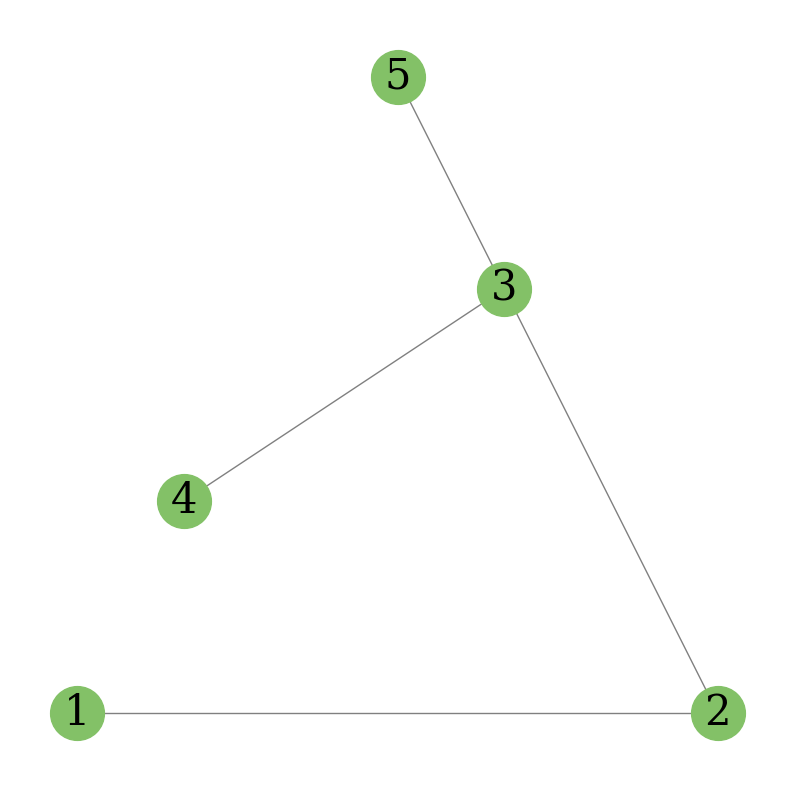

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
nx.draw(
    g, pos, with_labels=True,
    labels=node_labels,
    node_color='#83C167',
    ax=ax, edge_color='gray', node_size=1500, font_size=30, font_family='serif'
)
plt.savefig('simple_graph.png', bbox_inches='tight', transparent=True)

The formula: $\hat{A} = \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$

Element-wise: $(\hat{A})_{i,j} = \frac{\tilde{A}_{i,j}}{\sqrt{\tilde{d_i} \tilde{d_j}}}$

In [17]:
# Create the symmetrically normalized adjacency matrix
# Â = D̃^(-1/2) @ Ã @ D̃^(-1/2)
A_hat = D_mod_invroot @ A_mod @ D_mod_invroot

print("Symmetrically Normalized Adjacency Matrix (Â):")
print(A_hat)
print("\nNotice:")
print("- The matrix is symmetric (A_hat[i,j] = A_hat[j,i])")
print("- Each edge weight is normalized by sqrt(degree_i * degree_j)")
print("- Diagonal entries represent self-connections")

Symmetrically Normalized Adjacency Matrix (Â):
[[0.5        0.40824829 0.         0.         0.        ]
 [0.40824829 0.33333333 0.28867513 0.         0.        ]
 [0.         0.28867513 0.25       0.35355339 0.35355339]
 [0.         0.         0.35355339 0.5        0.        ]
 [0.         0.         0.35355339 0.         0.5       ]]

Notice:
- The matrix is symmetric (A_hat[i,j] = A_hat[j,i])
- Each edge weight is normalized by sqrt(degree_i * degree_j)
- Diagonal entries represent self-connections


## Part 4: Visualizing Message Passing in Action

Now let's see how information propagates through the graph using the normalized adjacency matrix. We'll simulate a "water drop" scenario where we start with a signal on node 0 and watch it spread through the graph.

**Simulation: Information Propagation**

We'll start with a signal (value of 1) on node 0 and observe how it spreads through the graph after multiple message passing iterations.

In [18]:
# Initialize: "water drop" on node 0
H = np.zeros((g.number_of_nodes(), 1))
H[0, 0] = 1  # Start with signal on node 0

# Run message passing for several iterations
iters = 10
results = [H.flatten()]  # Store results at each iteration

for i in range(iters):
    H = A_hat @ H  # One step of message passing
    results.append(H.flatten())

print(f"Initial signal input: {results[0]}")
print(f"\nFinal signal output after running {iters} steps of message-passing:")
print(results[-1])
print("\nNotice how the signal has spread from node 0 to all other nodes!")

Initial signal input: [1. 0. 0. 0. 0.]

Final signal output after running 10 steps of message-passing:
[0.18381719 0.20791335 0.20436693 0.13626176 0.13626176]

Notice how the signal has spread from node 0 to all other nodes!


**Visualization: Animation of Message Passing**

Let's create an animation showing how the signal propagates through the graph over time:


In [19]:
print(f"Initial signal input: {results[0]}")
print(f"Final signal output after running {iters} steps of message-passing:  {results[-1]}")

Initial signal input: [1. 0. 0. 0. 0.]
Final signal output after running 10 steps of message-passing:  [0.18381719 0.20791335 0.20436693 0.13626176 0.13626176]


You can save the animation to a video file if needed:


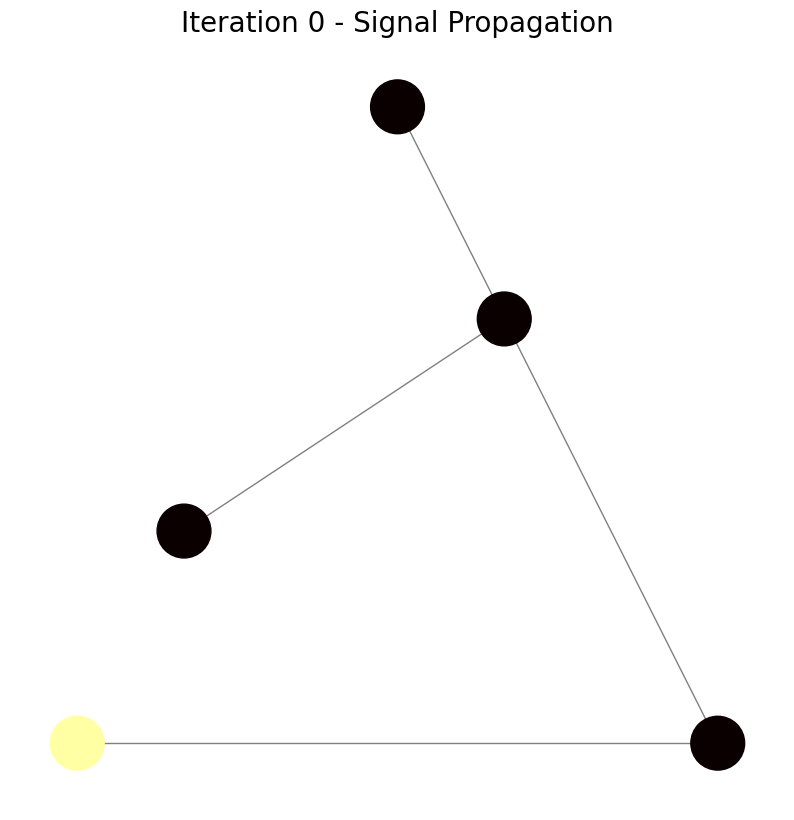

In [21]:
# Create animation showing message passing over iterations
fig, ax = plt.subplots(figsize=(10, 10))

kwargs = {'cmap': 'hot', 'node_size': 1500, 'edge_color': 'gray',
          'vmin': np.array(results).min(), 'vmax': np.array(results).max() * 1.1}

def update(idx):
    ax.clear()
    colors = results[idx]
    nx.draw(g, pos, node_color=colors, ax=ax, **kwargs)
    ax.set_title(f"Iteration {idx} - Signal Propagation", fontsize=20)

anim = animation.FuncAnimation(fig, update, frames=len(results), interval=1000, repeat=True)
# plt.show()

# Display animation (comment out if saving to file)
HTML(anim.to_html5_video())

## Summary

In this notebook, you learned:

1. **Message Passing Basics**: How matrix multiplication ($A \times X$) naturally implements neighborhood aggregation

2. **Aggregation Types**:
   - **Sum aggregation**: Simple sum of neighbor features ($A \times X$)
   - **Average aggregation**: Normalized by degree ($D^{-1} A \times X$)
   - **Symmetric normalization**: Used in GCNs ($\hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2} \times X$)

3. **Key Concepts**:
   - Degree matrix normalizes by neighborhood size
   - Self-connections allow nodes to retain their own features
   - Symmetric normalization provides numerical stability

4. **Visualization**: How information propagates through a graph over multiple message passing steps

**Next Steps**: In the next notebook, you'll use these concepts to build a complete Graph Convolutional Network from scratch!


In [ ]:
# Optional: Save animation to video file
# Uncomment the lines below to save the animation
# anim.save(
#     'water_drop.mp4',
#     dpi=600, bitrate=-1,
#     savefig_kwargs={'transparent': True, 'facecolor': 'none'},
# )
# print("✅ Animation saved as 'water_drop.mp4'")

In [ ]:
# Animation display moved to cell above